# Meridional Ray Tracing using the (Q, U) method (Kingslake, Ch. 2)

This notebook implements the ray tracing equations on Kinglake Ch 2, pg26. The meanings of the various variables are as follows:

|Name|Description|
|----|-----------|
| R  | Radii of surfaces |
| c  | Curvatures (1/R) of surfaces |
| d  | Thicknesses of elements, i.e, distances between surfaces|
| n  | Refractive indices: n_k is the left medium, n_{k+1} the right medium, with surface in betweeen|
| Q  | The perpendicular distance from surface vertex to ray being traced|
| I  | Angle of incidence |
| U  | Angle of ray with optical axis|

Primed quantities are after refraction and are stored in underscored_ variables. Angles are measured positive if clockwise to normal and negative otherwise. Radii are positive to right of surface and negative to left. 

The ray tracing equations are:

* sin I = Qc - sin U
* sin I' = (n/n') * sin I
* U' = U + I - I'
* Q' = (sin U' + sin I') / c

Alternately

* Q' = Q * (cos U' + cos I') / (cos U + cos I)

Transfer:

* Q2' = Q1' - d * sin U1'



**Warning:** This code is not hardened against division by zero as can happen for paraxial rays (Q[0]=0)


In [184]:
from math import sin, asin, sqrt, cos, pi
Blue=486.1
Green=546.1
Red=656.3

In [185]:
def r2d(x):
    return 180/pi*x


In [214]:
# Sellmeier cofficients table
Sellmeier_coeffs = {
    'AIR' : ([0.0], [0.0]),
    'BK7' : ([1.03961212, 0.231792344, 1.01046945], [0.00600069867, 0.0200179144, 103.560653]),
    'F2' : ([1.34533359, 0.209073176, 0.937357162], [0.00997743871, 0.0470450767, 111.886764]),
    'CAF2': ([0.437387571, 0.449211397, 0.152068715, 13.0020420], [0.00173799328, 0.00782718648, 0.0124086125, 4039.76541]),
    'N-ZK7': ([1.07715032, 0.168079109, 0.851889892], [0.00676601657, 0.0230642817, 89.0498778]),
    'KZFSN4': ([1.37994218, 0.168496708, 0.874885726], [0.00891159699, 0.040533407, 69.6628237]),
    'SK55':([1.15265225, 4.32145290e-001, 1.03215169e+000], [5.82679114e-003, 1.90244615e-002, 8.81750460e+001]),
    'N-BAF4':([1.42056328e+000,1.02721269e-001,1.14380976e+000],[9.42015382e-003,5.31087291e-002,1.10278856e+002])
}

OHARA_coeffs = {
    'O-FPL51': [2.2184385, -0.0059347504, 0.0080764899, 0.00016581036, -8.0553319e-06, 3.5839492e-07 ],
    'O-FPL53': [2.0531286, -0.0043190085, 0.0062752442, -9.8512972e-6, 1.364971e-5, -8.9037944e-7]
}

def n_from_lambda_nm_OHARA(wvl, name):
    '''
    OHARA doesn't use Sellmeier cofficients but a power series in (wvl^2).
    '''
    assert name[0:2] == 'O-'
    coeffs = OHARA_coeffs[name]
    n = 0.0
    wvl /= 1000.0 # The OHARA formula needs the wavelength in microns
    # The formula goes like:
    #   n^2 = A + B*wvl^2 + C*wvl^-2 + D*wvl^-4 + E*wvl^-6 + ...
    wvlsq = wvl * wvl
    n = coeffs[0] + coeffs[1] * wvlsq;
    wvl_fac = wvlsq
    for coeff in coeffs[2:]:
        n += coeff / wvl_fac
        wvl_fac *= wvlsq
    return sqrt(n)

def n_from_lambda_nm(wvl, name):
    '''
    Compute Refractive index computation by wavelength using the Sellmeier equation
    n^2= 1 + Sum(B[i]*wvl^2/(wvl^2 - C[i]))
    wvl is input in nano-meters, e.g. green is 546.0
    If the name begins with O-, compute using OHARA coefficients
    '''
    if name[0:2] == 'O-':
        return n_from_lambda_nm_OHARA(wvl, name)
    
    coeffs = Sellmeier_coeffs[name]
    B = coeffs[0]
    C = coeffs[1]
    assert len(B) > 0
    assert len(B) == len(C)
    n = 1.0;
    wvl /= 1000.0  # The cofficients need the wavelength in microns.
    wvlsq = wvl * wvl
    for i in range(len(B)):
        n += B[i] * wvlsq / (wvlsq - C[i])
    return sqrt(n)
    


In [216]:
%precision 6
n_from_lambda_nm(546, 'N-BAF4')

1.608976

In [188]:
def intersection_height(r1, r2, d):
    '''Given the radii r1 and r2 of a lens with axial thickness d, compute the intersection height.
    Return as (height, True) when defined and as (0.0, False) when not.'''
    A = (2*r2 + d)/(2*r1 - d)
    X2 = d/(A-1)
    X1 = A*X2
    YY = 2*r1*X1 - X1*X1
    if YY >= 0.0:
        return (sqrt(YY), True)
    return (0.0, False)

In [189]:
def meridional_ray_trace(wvl, R, d, medium_names, Q_init, show_vars):
    NSurf = len(R)
    assert NSurf + 1 == len(medium_names)
    assert NSurf - 1 == len(d)
    # Compute curvatures
    c=[1/x for x in R]
    # Find indices
    n = [n_from_lambda_nm(wvl, medium) for medium in medium_names]
    # Initialize all to 0
    Q     = [0.0 for k in range(NSurf)]
    I     = [0.0 for k in range(NSurf)]
    I_    = [0.0 for k in range(NSurf)]
    U     = [0.0 for k in range(NSurf)]
    U_    = [0.0 for k in range(NSurf)]
    Q_    = [0.0 for k in range(NSurf)]
    Y     = [0.0 for k in range(NSurf)]
    X     = [0.0 for k in range(NSurf)]
    sinI  = [0.0 for k in range(NSurf)]
    sinI_ = [0.0 for k in range(NSurf)]
    sinU  = [0.0 for k in range(NSurf)]
    sinU_ = [0.0 for k in range(NSurf)]
    # Start off with first value of Q for surface 0 as Q_init; this is the height of the paraxial ray being traced
    Q[0] = Q_init
    for k in range(NSurf):
        sinI[k] = Q[k]*c[k]-sin(U[k])
        sinI_[k] = (n[k]/n[k+1])*sinI[k]
        I_[k]= asin(sinI_[k])
        I[k]=asin(sinI[k])
        U_[k]=(U[k]+I[k]-I_[k])
        sinU_[k]=sin(U_[k])
        Q_[k]=(sinI_[k] + sinU_[k])/c[k]
        # Point of incidence
        Y[k] = sin(U[k] + I[k])/c[k]
        X[k] = (1 - cos(U[k] + I[k]))/c[k]
        if show_vars:
            print("Surface #", k)
            print('Q = {:15.4f}'.format(Q[k]))
            print("Q'= {:15.4f}".format(Q_[k]))
            print('I = {:15.4f}'.format(r2d(I[k])))
            print("I'= {:15.4f}".format(r2d(I_[k])))
            print('U = {:15.4f}'.format(r2d(U[k])))
            print("U'= {:15.4f}".format(r2d(U_[k])))
            print("X = {:15.4f}".format(X[k]))
            print("Y = {:15.4f}".format(Y[k]))
            print('')
        # Check ray height
        if k < NSurf - 1:
            height, intersection_defined = intersection_height(R[k], R[k+1], d[k])
            if intersection_defined and Y[k] > height:
                print('ERROR: ray trace misses lens for surface ', k, '; maximum height is ', height)
                return
        # Transfer
        if k < NSurf-1:
            Q[k+1] = Q_[k] - d[k]*sinU_[k]
            U[k+1] = U_[k]
    
    bfl = Q_[NSurf-1]/sinU_[NSurf-1]
    if show_vars:
        print('BFL={:15.4f}'.format(bfl))
    return bfl



In [190]:
%precision 4
R=[7.3895,-5.1784,-16.2225]
d=[1.05,0.40]
media=['AIR', 'CAF2', 'BK7', 'AIR']
meridional_ray_trace(546, R, d, media, 2.0, True)

Surface # 0
Q =          2.0000
Q'=          2.0161
I =         15.7032
I'=         10.8723
U =          0.0000
U'=          4.8309
X =          0.2758
Y =          2.0000

Surface # 1
Q =          1.9277
Q'=          1.9425
I =        -27.1597
I'=        -25.5490
U =          4.8309
U'=          3.2202
X =         -0.3883
Y =          1.9674

Surface # 2
Q =          1.9200
Q'=          1.8910
I =        -10.0512
I'=        -15.3705
U =          3.2202
U'=          8.5396
X =         -0.1152
Y =          1.9295

BFL=        12.7348


12.7348

In [191]:
# 200mm f/15 BK7/F2 airspaced achromat
R=[1738.701, -1076.634, -1076.634, -4808.732]
d=[25, 10.02772, 17]
media=['AIR', 'BK7', 'AIR', 'F2', 'AIR']
meridional_ray_trace(546, R, d, media, 100, True)/200

Surface # 0
Q =        100.0000
Q'=        100.0373
I =          3.2971
I'=          2.1703
U =          0.0000
U'=          1.1268
X =          2.8781
Y =        100.0000

Surface # 1
Q =         99.5456
Q'=         98.9873
I =         -6.4379
I'=         -9.8046
U =          1.1268
U'=          4.4935
X =         -4.6221
Y =         99.6558

Surface # 2
Q =         98.2017
Q'=         98.7966
I =         -9.7621
I'=         -5.9927
U =          4.4935
U'=          0.7241
X =         -4.5486
Y =         98.8620

Surface # 3
Q =         98.5817
Q'=         98.5139
I =         -1.8990
I'=         -3.0851
U =          0.7241
U'=          1.9102
X =         -1.0110
Y =         98.6024

BFL=      2955.4201


14.7771

### Plotting longitudinal spherical aberration
We can use the above function to plot the computed back-focal length against ray height. From the plot, the lens is well corrected for +/- 2.0 ray height and then rapidly deteriorates after this aperture.

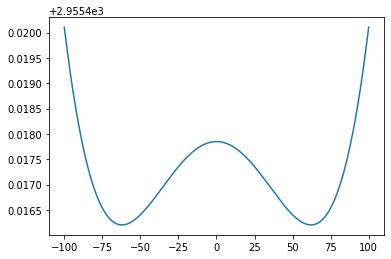

In [192]:
%matplotlib inline
import matplotlib.pyplot as plt

ray_height = -100
xvals=list()
yvals=list()
while ray_height <= 100:
    xvals.append(ray_height)
    yvals.append(meridional_ray_trace(546, R, d, media, ray_height, False))
    ray_height += 0.05
    
plt.plot(xvals, yvals)


### The color vs focal-length curve for the 200mm f/15 achromatic doublet

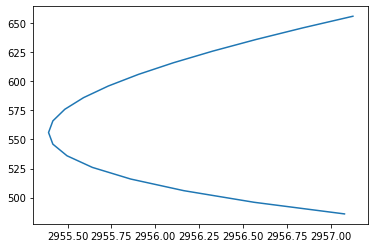

In [193]:
wvl = 486
xvals=list()
yvals=list()
while wvl <= 656:
    yvals.append(wvl)
    xvals.append(meridional_ray_trace(wvl, R, d, media, 70.7, False))
    wvl += 10
plt.plot(xvals, yvals)

### The color vs focal-length curve for an 200mm f/15 apochromatic doublet

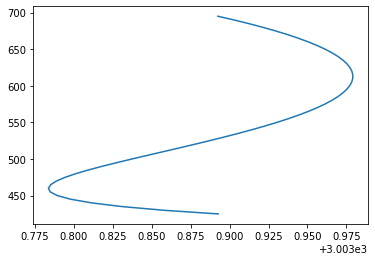

In [194]:
R=[1383.366, 513.2866, 513.2866, -4808.375]
d=[20, 18.10669, 30]
media=['AIR', 'N-ZK7', 'AIR', 'O-FPL53', 'AIR']
wvl = 425
xvals=list()
yvals=list()
while wvl < 700:
    yvals.append(wvl)
    xvals.append(meridional_ray_trace(wvl, R, d, media, 70.7, False))
    wvl += 5
plt.plot(xvals, yvals)

### Color curves for f/15 achromat

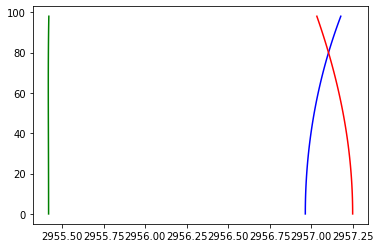

In [206]:
R=[1738.701, -1076.634, -1076.634, -4808.732]
d=[25, 10.02772, 17]
media=['AIR', 'BK7', 'AIR', 'F2', 'AIR']

z_height = 0.01  # Can't be 0 as equations break down
yvals=list()
xvals_blue_focus=list()
xvals_green_focus=list()
xvals_red_focus=list()
while z_height <= 100.0:
    yvals.append(z_height)
    xvals_blue_focus.append(meridional_ray_trace(Blue, R, d, media, z_height, False))
    xvals_green_focus.append(meridional_ray_trace(Green, R, d, media, z_height, False))
    xvals_red_focus.append(meridional_ray_trace(Red, R, d, media, z_height, False))
    z_height += 2
plt.plot(xvals_blue_focus, yvals, color='blue')
plt.plot(xvals_green_focus, yvals, color='green')
plt.plot(xvals_red_focus, yvals, color='red')

### Color curves for the f/15 apochromat
We can plot a focus curve vs. zonal height for three colors.

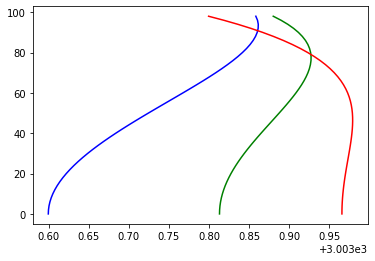

In [195]:

R=[1383.366, 513.2866, 513.2866, -4808.375]
d=[20, 18.10669, 30]
media=['AIR', 'N-ZK7', 'AIR', 'O-FPL53', 'AIR']
z_height = 0.01  # Can't be 0 as equations break down
yvals=list()
xvals_blue_focus=list()
xvals_green_focus=list()
xvals_red_focus=list()
while z_height <= 100.0:
    yvals.append(z_height)
    xvals_blue_focus.append(meridional_ray_trace(Blue, R, d, media, z_height, False))
    xvals_green_focus.append(meridional_ray_trace(Green, R, d, media, z_height, False))
    xvals_red_focus.append(meridional_ray_trace(Red, R, d, media, z_height, False))
    z_height += 2
plt.plot(xvals_blue_focus, yvals, color='blue')
plt.plot(xvals_green_focus, yvals, color='green')
plt.plot(xvals_red_focus, yvals, color='red')

### 200mm f/8 oiled triplet - NPN, chromatic shift and color curves

In [207]:
R=[753.6887, 434.1788, -582.5756, -2184.093]
d=[20, 35, 20]
media=['AIR', 'N-ZK7', 'O-FPL53', 'N-ZK7', 'AIR']

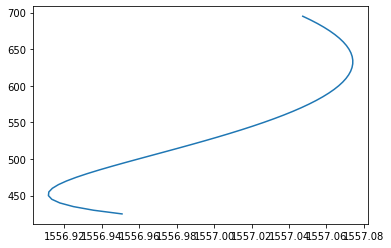

In [211]:
wvl = 425
xvals=list()
yvals=list()
while wvl < 700:
    yvals.append(wvl)
    xvals.append(meridional_ray_trace(wvl, R, d, media, 70.71, False))
    wvl += 5
plt.plot(xvals, yvals)

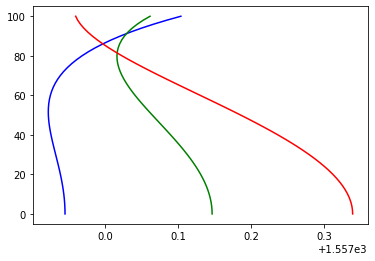

In [209]:
z_height = 0.01  # Can't be 0 as equations break down
yvals=list()
xvals_blue_focus=list()
xvals_green_focus=list()
xvals_red_focus=list()
while z_height <= 100.01:
    yvals.append(z_height)
    xvals_blue_focus.append(meridional_ray_trace(Blue, R, d, media, z_height, False))
    xvals_green_focus.append(meridional_ray_trace(Green, R, d, media, z_height, False))
    xvals_red_focus.append(meridional_ray_trace(Red, R, d, media, z_height, False))
    z_height += 2
plt.plot(xvals_blue_focus, yvals, color='blue')
plt.plot(xvals_green_focus, yvals, color='green')
plt.plot(xvals_red_focus, yvals, color='red')

### 200mm f/15 Super achromatic triplet

In [230]:
R=[1611.038, -650.8718, 367.3269, 14277.27]
d=[27, 16, 29]
media=['AIR', 'SK55', 'KZFSN4', 'N-BAF4', 'AIR']

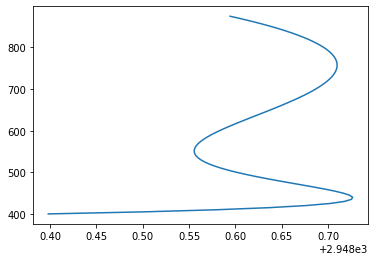

In [236]:
wvl = 400
xvals=list()
yvals=list()
while wvl < 880:
    yvals.append(wvl)
    xvals.append(meridional_ray_trace(wvl, R, d, media, 84, False))
    wvl += 5
plt.plot(xvals, yvals)

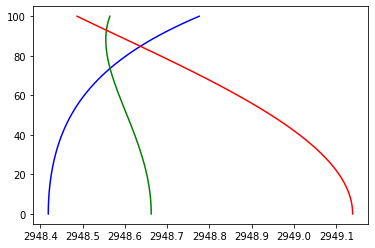

In [232]:
z_height = 0.01  # Can't be 0 as equations break down
yvals=list()
xvals_blue_focus=list()
xvals_green_focus=list()
xvals_red_focus=list()
while z_height <= 100.01:
    yvals.append(z_height)
    xvals_blue_focus.append(meridional_ray_trace(Blue, R, d, media, z_height, False))
    xvals_green_focus.append(meridional_ray_trace(Green, R, d, media, z_height, False))
    xvals_red_focus.append(meridional_ray_trace(Red, R, d, media, z_height, False))
    z_height += 2
plt.plot(xvals_blue_focus, yvals, color='blue')
plt.plot(xvals_green_focus, yvals, color='green')
plt.plot(xvals_red_focus, yvals, color='red')